In [45]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthEnd

# RMB CPI Nowcasting Challenge
## Thoughts on building a CPI forecasting model
**By Arno Pienaar (2nd place overall)**

RMB challenged the Zindi data science community to build machine learning models that could be used to accurately forecast upcoming CPI releases. The challenge of forecasting inflation levels prior to the official Stats SA release goes beyond an interesting academic exercise with considerable commercial value arising from an accurate prediction that allows market participants to anticipate the second order impacts on lending rates or bond prices in response to the CPI publication.

This notebook outlines some of the thought processes and considerations that went into building the machine learning model which placed second in the competition. At it's core, I believe forecasting CPI is primarily a data selection and feature engineering problem, as opposed to a pure modelling problem. A sound fundamental understanding of the drivers of CPI will provide the foundation for a robust model.

### Competition Background and Structure
The competition consisted of five rounds of mini-challenges from April to August. To qualify as an entrant to the final round, participants had to submit forecasts for at least 3 of the 5 mini-challenges. The final then consisted of 3 months of forecasts, from September to November, using an unchanged model to allow judging of model consistency.

### Prediction Target Variable
The challenge required detailed CPI predictions for all urban areas across all 12 categories tracked by Stats SA and a consolidated forecast of headline CPI (In other words, 13 forecasts).
#### Forecasting Month-on-Month Change
 The aim of the challenge was to forecast the actual index levels. To achieve this, I adopted an indirect approach by forecasting month-on-month change in each category and then extrapolating this into the forecast price index level. This decision was based on the intuition that the machine learning model might get tripped up by the autocorrelation present in the time series and accordingly it may be more appropriate to isolate the underlying month-on-month change as the target variable. However, I did not empirically test whether there was any benefit of selecting this approach over forecasting the absolute index level directly, so this may have been unnecessary.

 #### Competition Forecasts
 The below table compares the model forecasts against published CPI and shows the model prediction error in absolute terms.

In [46]:
# Table of results comparing actual CPI vs predicted CPI
results = pd.read_excel('./Data/Results.xlsx')
results.round(2)

# Set colormap for prediction error columns
cm = sns.diverging_palette(220, 20, as_cmap=True)

# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px'),
  ('text-align', 'center')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

# Set rounding formatting on numeric columns in table display
colFormat = {}
numericColumns = results.select_dtypes(include='number').columns
for col in numericColumns:
     colFormat[col] = "{:.2f}"

# Display table with style applied
(results.style
  .background_gradient(cmap=cm, subset=['September Absolute Prediction Error','October Absolute Prediction Error', 'November Absolute Prediction Error'])
  .set_table_styles(styles)
  .format(colFormat))


,Category Code,Category Description,September Actual,September Predicted,September Absolute Prediction Error,October Actual,October Predicted,October Absolute Prediction Error,November Actual,November Predicted,November Absolute Prediction Error
0,CPS00000,Headline CPI,111.80,111.86,0.06,112.80,112.52,0.28,112.70,112.58,0.12
1,CPS01000,Food and non-alcoholic beverages,119.20,118.87,0.33,121.00,119.89,1.11,122.00,121.61,0.39
2,CPS02000,Alcoholic beverages and tobacco,111.10,111.90,0.80,111.60,111.51,0.09,111.60,111.98,0.38
3,CPS03000,Clothing and footwear,104.80,104.91,0.11,105.00,105.03,0.03,105.10,105.20,0.10
4,CPS04000,Housing and utilities,109.40,109.53,0.13,109.40,109.50,0.10,109.50,109.50,0.00
5,CPS05000,Household contents and services,108.80,108.56,0.24,109.10,109.27,0.17,108.90,109.23,0.33
6,CPS06000,Health,110.80,110.83,0.03,111.20,111.06,0.14,111.40,111.41,0.01
7,CPS07000,Transport,116.70,116.69,0.01,120.00,119.09,0.91,118.00,117.03,0.97
8,CPS08000,Communication,99.50,99.47,0.03,99.50,99.48,0.02,99.30,99.43,0.13
9,CPS09000,Recreation and culture,106.30,105.96,0.34,106.30,106.52,0.22,106.40,106.52,0.12


## Data Selection
The competition rules allowed participants to freely select publicly available data sources that may contain signal useful in forecasting CPI. My core hypotheses was that inflation in the current South African economic context is primarily driven by cost-push factors, with the primary drivers being foreign exchange rates and petrol prices. The prevailing economic headwinds that South Africa has experienced over the last decade has resulted in such strain on the average consumer that traditional demand-pull inflationary factors are likely to have muted impact.  

The above hypotheses is reflected in the datasources selected, which is weighted to the capture these cost pressures.

|Dataset |Source       |Description  |
|:------:|:-----------:|:-----------:|
|CPI     |Stats SA     |Historic detailed CPI (P0141) data from January 2008 to current.|
|PPI     |Stats SA     |Historic detailed PPI (P0142.1) data from January 2013 to current.|
|USDZAR  |SARB         |Historic USDZAR rate as per SARB.|
|Prime Rate|SARB       |Historic Prime Lending Rate as per SARB.|
|Petrol Price|SAPIA    |Historic and current petroleum product prices.| 

## Feature Selection and Engineering
### Autocorrelation
A core assumption that informed feature engineering was the notion of "momentum" in price level changes. The starting assumption was that price changes tend to maintain consistent direction and momentum in terms of magnitude from one month to the next. This would imply some level of autocorrelation in the CPI timeseries. In the absence of a more sophisticated model, a forecaster might reasonably default to forecasting that the year-on-year change from the prior month will persist. This concept is illustrated in the graph below which clearly illustrates the correlation between year-on-year headline inflation from one month to the next. Some features were developed to capture this pattern.

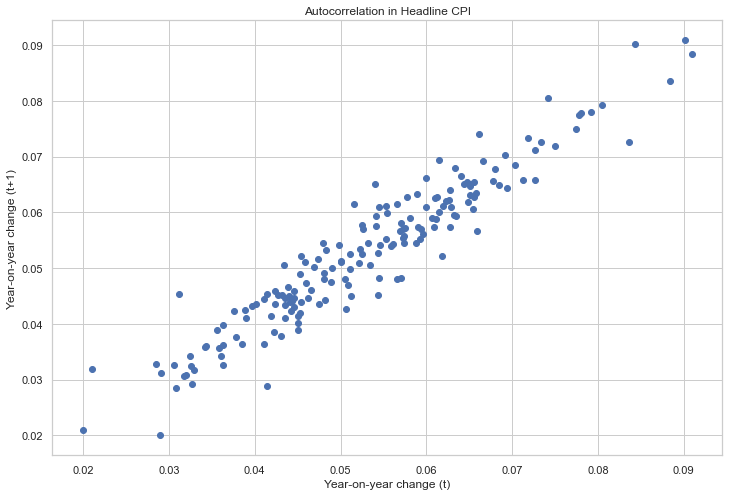

In [47]:
# Create a scatterplot illustrating autocorrelation

# Load data and define the CPI categories for filtering
cpiTimeSeries = pd.read_excel('./Data/Historic CPI.xlsx')
vizCats = ['CPT00000', 'CPT10000']

# Drop unneccessary fields from dataset
cpiTimeSeries = cpiTimeSeries.drop(
    cpiTimeSeries.loc[:, 'H01':'H02'] + cpiTimeSeries.loc[:, 'H04':'H25'], axis=1)

# Filter to only include necessary categories
cpiTimeSeries = cpiTimeSeries[cpiTimeSeries['H03'].isin(vizCats)]

# Reshape the horizontal monthly values to a single column series of values
cpiTimeSeries = pd.melt(cpiTimeSeries, var_name='Date', id_vars=['H03'])

# Transform string date to datetime
cpiTimeSeries['Date'] = pd.to_datetime(
    cpiTimeSeries['Date'].str[2:], format='%m%Y')
cpiTimeSeries['Date'] = cpiTimeSeries['Date'] + MonthEnd()

# Create series for visualization
headlineCPI = cpiTimeSeries[cpiTimeSeries['H03'] == 'CPT00000']
headlineCPI.set_index(['Date'], inplace=True) 
headlineCPI = headlineCPI['value']
headlineCPI = headlineCPI.pct_change(periods=12)

# Create scatterplot
sns.set_theme(style="whitegrid")
sns.color_palette('pastel')
fig = plt.figure(figsize=(12,8))
pd.plotting.lag_plot(headlineCPI, lag=1) 
plt.plot()
plt.title('Autocorrelation in Headline CPI')
plt.xlabel('Year-on-year change (t)')
plt.ylabel('Year-on-year change (t+1)')
plt.show()

### Delayed Transfer of Price Changes
Another key assumption was that producers may not immediately react to pass price increases through to consumers. Features were developed across multiple time horizons to allow the model to detect patterns in the rate at which certain price increases are passed through to the consumers. As an example, an increase in the price of petrol would most likely feed through to the Transport category immediately, but the impact on Food Prices may be delayed by a month or two as retail prices are slower to react.

### Seasonality
Price level changes exhibit sensitivity to seasonality, particularly on certain sub categories. Lagged features were created to ensure this characteristic is exposed to the model during training. To illustrate this, the below visualization shows the extreme example of the Education sub-sector that effectively adjusts price levels once per annum. Some other subsectors also display a seasonal cyclicality, but obviously not to this extreme.

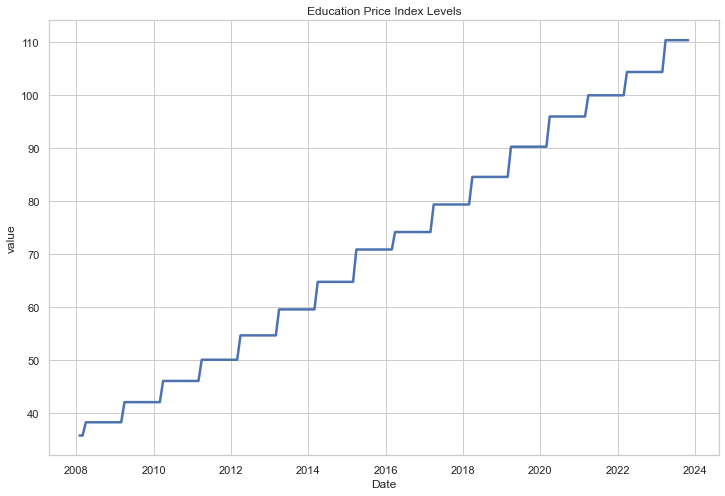

In [48]:
# Create a line plot illustrating seasonality in the Education sub-sector.

# Create series for visualization
educationCPI = cpiTimeSeries[cpiTimeSeries['H03'] == 'CPT10000']
educationCPI.set_index(['Date'], inplace=True) 
educationCPI = educationCPI['value']

# Create lineplot
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=educationCPI, linewidth=2.5)
plt.plot()
plt.title('Education Price Index Levels')
plt.show()

## Model Selection and Configuration
The scikit-learn Random Forest regressor was used in the challenge. This model selection was based on the ability of the Random Forest algorithm to detect non-linear relationships within the dataset. The decision was supported by promising cross-validation results during model testing. The XGBoost regressor algorithm was also considered for similar reasons, but surprisingly performed consistently worse than the Random Forest model. 

A separate model instance was trained for each subcategory of CPI and the results of these forecasts weighted to calculate Headline CPI. Hypertuning of the model parameters was also done on each model instance separately, but this was only done once in April and not revisited since. The returns from hyperparameter tuning did not seem significant enough to warrant additional time investment.

## Future Areas of Improvement
There are a few areas that could be explored to potentially improve the predictive power of the model. The most promising of these, in my opinion, would be to attempt to replicate the inputs to Stats SA's CPI calculation more closely. As an example, web scraping may allow the forecaster to assemble a representative proxy of items that composes the basket of food products tracked by Stats SA. Similarly, a more labour intensive approach may be employed to gather similar data inputs for other sectors (e.g. Health or Restaurants and hotels). These inputs would likely yield a marginally improved forecast, particularly in instances where price levels jump idiosyncratically, but these incremental returns in precision are, in my opinion, diminishing. 

## Conclusion
The process that I followed to create this CPI forecasting model was largely informed by classic economic theory. The risk of introducing noise by selecting exotic datasets appeared too high, so I instead chose to focus on extracting maximum signal from a limited range of datasets. The model performed well throughout the evaluation period, only missing the mark widely on the "Restaurant and Hotels" category in October (It is still not clear what drove the sharp increase in hotel prices during that month). Although I am pleased with the observed predictive power of the model, one would have to evaluate the performance through a full cycle of rising and descending inflation rates to properly evaluate the model.

The RMB CPI Nowcasting Challenge presented a unique opportunity for analysts and data scientists to compete in a prestigious challenge that is relevant in the local South African context. I would like to express sincere gratitude to RMB for their generous sponsorship of this competition and the Zindi team for their tireless efforts to keep things running smoothly. Initiatives like this augur well for the future growth of South Africa's data analytics capabilities!